# SQS elastic constants

This notebook demonstrates the functionality of job classes designed to calculate chemistry-dependent elastic data by averaging over one or more special-quasirandom structures.

In [35]:
from pyiron import Project
import pyiron_contrib
from elastic import ElasticMatrixJob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [ ]:
pr = Project('scratch')
#pr.remove_jobs(recursive=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-36-9e434929384b>", line 1, in <module>
    pr = Project('scratch')
  File "/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/pyiron/project.py", line 108, in __init__
    super(Project, self).__init__(
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/project/generic.py", line 134, in __init__
    super(Project, self).__init__(path=path)
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/project/path.py", line 228, in __init__
    generic_path = self._convert_str_to_generic_path(path)
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/project/path.py", line 371, in _convert_str_to_generic_path
    posixpath.abspath(os.curdir)
  File "/opt/conda/lib/python3.8/posixpath.py", line 379, in abspath
    cwd = os.getcwd()
F

# Setup reference jobs

The input to these SQS elastic job classes is quite minimal, rather run parameters are passed in in the form of reference jobs.

Of special importance are the `SQSJob` type reference, which handles the generation of special quasirandom structures, and `ElasticMatrixJob`, which computes the elastic constants. Thankfully, these jobs already existed, so the development of the new SQS elastic jobs was just a matter of stringing them together. 

An advantage of this setup is that any new improvements to the functionality of these underlying jobs is included in the SQS elastic jobs without having to modify SQS elastic code specifically, since they appear simply as references. However, the flip side of the coin is that the functionality of these jobs was not exhaustively tested. Results are very reasonable for the FCC Al system tested, but keep your physicist hat on when running the code and ensure that your results are coming out sensibly.

The final and most basic reference is the model which will interpret atomic positions to produce forces and energies. Here we'll use Lammps, but, if you have a lot of processor power lying around, there should be no barrier to using a quantum mechanical code like Vasp instead.

Here, we'll scale a lot of the input parameters way back so the calculations run faster.

In [36]:
lammps = pr.create_job(pr.job_type.Lammps, 'hr')
lammps.structure = pr.create_ase_bulk('Cu', cubic=True).repeat(5)
lammps.structure[:3] = 'Ni'

DEBUG:pyiron_log:Not supported parameter used!


ERROR! Session/line number was not unique in database. History logging moved to new session 38


In [37]:
lammps.list_potentials()

['FeCuNi_eam_alloy',
 '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1',
 '2009--Bonny-G--Fe-Cu-Ni--LAMMPS--ipr1',
 '1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1',
 '2009--Bonny-G--Fe-Cu-Ni--LAMMPS--ipr1',
 '2013--Onat-B--Cu-Ni--LAMMPS--ipr2',
 '2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr1',
 '2013--Onat-B--Cu-Ni--LAMMPS--ipr1',
 '2018--Farkas-D--Fe-Ni-Cr-Co-Cu--LAMMPS--ipr2',
 '1989--Adams-J-B--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 '1986--Foiles-S-M--Ag-Au-Cu-Ni-Pd-Pt--LAMMPS--ipr1',
 'EAM_Dynamo_BonnyPasianotCastin_2009_FeCuNi__MO_469343973171_005',
 'EAM_Dynamo_OnatDurukanoglu_2014_CuNi__MO_592013496703_005',
 'EMT_Asap_Standard_JacobsenStoltzeNorskov_1996_AlAgAuCuNiPdPt__MO_115316750986_001']

In [38]:
lammps.potential = lammps.list_potentials()[1]
lammps.potential

,Config,Filename,Model,Name,Species
170,"[pair_style eam\n, pair_coeff 1 1 Cu_smf7.eam\...",[NISTiprpy/1985--Foiles-S-M--Ni-Cu--LAMMPS--ip...,NISTiprpy,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,"[Cu, Ni]"
385,"[pair_style eam\n, pair_coeff 1 1 Cu_smf7.eam\...",[NISTiprpy/1985--Foiles-S-M--Ni-Cu--LAMMPS--ip...,NISTiprpy,1985--Foiles-S-M--Ni-Cu--LAMMPS--ipr1,"[Cu, Ni]"


In [39]:
sqs = pr.create_job(pr.job_type.SQSJob, 'sr')
sqs.input.iterations = 100
sqs.input.weights = None
sqs.input.n_output_structures = 2 

In [40]:
elastic = pr.create_job(ElasticMatrixJob, 'er')
elastic.input['num_of_points'] = 3
elastic.input['fit_order'] = 2
elastic.input['eps_range'] = 0.005
elastic.input['relax_atoms'] = False
elastic.input['sqrt_eta'] = False

# Option 1: A single composition

If we're interested in a single chemical composition, we can run the calculation for that directly and look at the statistical properties of the output.

In [ ]:
sqs_elastic = pr.create_job(pr.job_type.SQSElasticConstants, 'single')
sqs_elastic.ref_ham = lammps
sqs_elastic.ref_sqs = sqs
sqs_elastic.ref_elastic = elastic
sqs_elastic.run()

2020-11-06 07:13:38,869 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! single


This group does not exist in the HDF5 file single_sqs
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file struct_1
This group does not exist in the HDF5 file single_min
This group does not exist in the HDF5 file s_e_0
This group does not exist in the HDF5 file s_02_e_m0_00500
This group does not exist in the HDF5 file s_02_e_0_00500
This group does not exist in the HDF5 file s_03_e_m0_00500
This group does not exist in the HDF5 file s_03_e_0_00500
This group does not exist in the HDF5 file s_04_e_m0_00500
This group does not exist in the HDF5 file s_04_e_0_00500
This group does not exist in the HDF5 file s_05_e_m0_00500
This group does not exist in the HDF5 file s_05_e_0_00500
This group does not exist in the HDF5 file s_06_e_m0_00500
This group does not exist in the HDF5 file s_06_e_0_00500
This group does not exist in the HDF5 file s_07_e_m0_00500
This group does not exist in the HDF5 file s_07_e_0_00500
This group does not exist in the HDF5

INFO:pyiron_log:run job: single id: None, status: initialized


This group does not exist in the HDF5 file s_16_e_0_00500
This group does not exist in the HDF5 file s_17_e_m0_00500
This group does not exist in the HDF5 file s_17_e_0_00500
This group does not exist in the HDF5 file s_18_e_m0_00500
This group does not exist in the HDF5 file s_18_e_0_00500
This group does not exist in the HDF5 file s_19_e_m0_00500
This group does not exist in the HDF5 file s_19_e_0_00500
This group does not exist in the HDF5 file s_20_e_m0_00500
This group does not exist in the HDF5 file s_20_e_0_00500
This group does not exist in the HDF5 file s_21_e_m0_00500
This group does not exist in the HDF5 file s_21_e_0_00500
This group does not exist in the HDF5 file s_22_e_m0_00500
This group does not exist in the HDF5 file s_22_e_0_00500
This group does not exist in the HDF5 file struct_1
This group does not exist in the HDF5 file single_elastic
This group does not exist in the HDF5 file single


DEBUG:pyiron_log:Not supported parameter used!
2020-11-06 07:13:40,749 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! single_el_job


This group does not exist in the HDF5 file single_el_job


DEBUG:pyiron_log:sql_query: {'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:Not supported parameter used!
INFO:pyiron_log:run job: single id: 1111, status: created
INFO:pyiron_log:run job: single_sqs id: None, status: initialized
DEBUG:pyiron_log:Not supported parameter used!
INFO:pyiron_log:run job: single_sqs id: 1112, status: created


The job single_el_job was saved and received the ID: 1110
The job single was saved and received the ID: 1111
The job single_sqs was saved and received the ID: 1112
Threads used: 1


INFO:pyiron_log:run job: single_min id: None, status: initialized
INFO:pyiron_log:run job: single_min id: 1113, status: created
INFO:pyiron_log:job: single_min id: 1113 run parallel master (modal)
DEBUG:pyiron_log:single_min child project /home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/
DEBUG:pyiron_log:sql_query: {'job': 'struct_0', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/single_min_hdf5/'}
DEBUG:pyiron_log:sql_query: {'job': 'struct_0', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/single_min_hdf5/%'}


The job single_min was saved and received the ID: 1113


DEBUG:pyiron_log:create_job:: /home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/single_min single_min /single_min 1113
INFO:pyiron_log:single_min: run job struct_0
DEBUG:pyiron_log:create job: job: struct_0 id: None 1113
INFO:pyiron_log:run job: struct_0 id: None, status: initialized
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
INFO:pyiron_log:run job: struct_0 id: 1114, status: created
INFO:pyiron_log:job: struct_0 id: 1114, status: submitted, run job (modal)
INFO:pyiron_log:job: struct_0 id: 1114, status: collect, output: LAMMPS (3 Mar 2020)
Reading data file ...
  orthogonal box = (0 0 0) to (18.05 18.05 18.05)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  500 atoms
  read_data CPU = 0.000913858 secs
Neighbor list info ...
  update every 1 steps, delay 0 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 6.95
  ghost atom cutoff = 6.95
  binsi

The job struct_0 was saved and received the ID: 1114


DEBUG:pyiron_log:Not supported parameter used!
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-f6e48a49ba4c>", line 5, in <module>
    sqs_elastic.run()
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/job/generic.py", line 684, in run
    self._run_if_new(debug=debug)
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/job/generic.py", line 1394, in _run_if_new
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/job/generic.py", line 686, in run
    que_id = self._run_if_created()
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/job/generic.py", line 1411, in _run_if_created
    self.run_static()
  File "/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/pyiron_contrib/atomistic/atomistics/master/sqselastic.py", line 322, in run_static
    super().run_static()
  File "/opt/conda/lib/

In [ ]:
sqs_elastic.output.elastic_matrices.sem

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-41-9970a5f58af9>", line 1, in <module>
    sqs_elastic.output.elastic_matrices.sem
  File "/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/pyiron_contrib/atomistic/atomistics/master/sqselastic.py", line 57, in sem
    return self._data.std(axis=self.axis) / len(self._data)
  File "/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py", line 233, in _std
    ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
  File "/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py", line 179, in _var
    rcount = _count_reduce_items(arr, axis)
  File "/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py", line 66, in _count_reduce_items
    items *= arr.shape[mu.normalize_axis_index(ax, arr.ndim)]
numpy.AxisError: axis 0

In [41]:
sqs_elastic_loaded = pr.load(sqs_elastic.job_name)

DEBUG:pyiron_log:sql_query: {'job': 'single', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}


ERROR! Session/line number was not unique in database. History logging moved to new session 40


DEBUG:pyiron_log:sql_query: {'job': 'single_ham_ref', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'job': 'single_sqs_ref', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'job': 'single_el_job', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}


In [ ]:
sqs_elastic_loaded.output.elastic_matrices.mean

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-5bc00bffb007>", line 1, in <module>
    sqs_elastic_loaded.output.elastic_matrices.mean
  File "/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/pyiron_contrib/atomistic/atomistics/master/sqselastic.py", line 49, in mean
    return self._data.mean(axis=self.axis)
  File "/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py", line 147, in _mean
    rcount = _count_reduce_items(arr, axis)
  File "/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py", line 66, in _count_reduce_items
    items *= arr.shape[mu.normalize_axis_index(ax, arr.ndim)]
numpy.AxisError: axis 0 is out of bounds for array of dimension 0

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/op

In [42]:
sqs_elastic_loaded.output.residual_pressures

None

# Option 2: Scan various compositions

Alternatively, we might want to look for chemical trends across multiple different compositions. This is also possible. 

In [ ]:
sqs_elastic_ref = pr.create_job(pr.job_type.SQSElasticConstants, 'se')
sqs_elastic_ref.ref_ham = lammps
sqs_elastic_ref.ref_sqs = sqs
sqs_elastic_ref.ref_elastic = elastic

job = sqs_elastic_ref.create_job(pr.job_type.SQSElasticConstantsList, 'scan')
job.input.compositions = [
    {'Cu': 1., 'Ni': 0.},
    {'Cu': 0.95, 'Ni': 0.05},
    {'Cu': 0.90, 'Ni': 0.10},
    {'Cu': 0.85, 'Ni': 0.15},
    {'Cu': 0.80, 'Ni': 0.20},
    {'Cu': 0.70, 'Ni': 0.30},
    {'Cu': 0.60, 'Ni': 0.40},
    {'Cu': 0.50, 'Ni': 0.50},
    {'Cu': 0.40, 'Ni': 0.60},
    {'Cu': 0.30, 'Ni': 0.70},
    {'Cu': 0.20, 'Ni': 0.80},
    {'Cu': 0.10, 'Ni': 0.90},
    {'Cu': 0., 'Ni': 1.}
]
job.run()

2020-11-06 07:13:46,531 - pyiron_log - WARNING - No HDF5 file found - remove database entry and create new job! scan


ERROR! Session/line number was not unique in database. History logging moved to new session 41
This group does not exist in the HDF5 file Cu10_Ni00_sqs
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu10_Ni00_min
This group does not exist in the HDF5 file s_e_0
This group does not exist in the HDF5 file s_01_e_m0_00500
This group does not exist in the HDF5 file s_01_e_0_00500
This group does not exist in the HDF5 file s_08_e_m0_00500
This group does not exist in the HDF5 file s_08_e_0_00500
This group does not exist in the HDF5 file s_23_e_m0_00500
This group does not exist in the HDF5 file s_23_e_0_00500
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu10_Ni00_elastic
This group does not exist in the HDF5 file Cu10_Ni00
This group does not exist in the HDF5 file Cu095_Ni005_sqs
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu095_Ni005_min
Thi

This group does not exist in the HDF5 file s_18_e_0_00500
This group does not exist in the HDF5 file s_19_e_m0_00500
This group does not exist in the HDF5 file s_19_e_0_00500
This group does not exist in the HDF5 file s_20_e_m0_00500
This group does not exist in the HDF5 file s_20_e_0_00500
This group does not exist in the HDF5 file s_21_e_m0_00500
This group does not exist in the HDF5 file s_21_e_0_00500
This group does not exist in the HDF5 file s_22_e_m0_00500
This group does not exist in the HDF5 file s_22_e_0_00500
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu085_Ni015_elastic
This group does not exist in the HDF5 file Cu085_Ni015
This group does not exist in the HDF5 file Cu08_Ni02_sqs
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu08_Ni02_min
This group does not exist in the HDF5 file s_e_0
This group does not exist in the HDF5 file s_02_e_m0_00500
This group does not exist in t

This group does not exist in the HDF5 file s_20_e_0_00500
This group does not exist in the HDF5 file s_21_e_m0_00500
This group does not exist in the HDF5 file s_21_e_0_00500
This group does not exist in the HDF5 file s_22_e_m0_00500
This group does not exist in the HDF5 file s_22_e_0_00500
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu06_Ni04_elastic
This group does not exist in the HDF5 file Cu06_Ni04
This group does not exist in the HDF5 file Cu05_Ni05_sqs
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu05_Ni05_min
This group does not exist in the HDF5 file s_e_0
This group does not exist in the HDF5 file s_02_e_m0_00500
This group does not exist in the HDF5 file s_02_e_0_00500
This group does not exist in the HDF5 file s_03_e_m0_00500
This group does not exist in the HDF5 file s_03_e_0_00500
This group does not exist in the HDF5 file s_04_e_m0_00500
This group does not exist in the H

This group does not exist in the HDF5 file s_18_e_0_00500
This group does not exist in the HDF5 file s_19_e_m0_00500
This group does not exist in the HDF5 file s_19_e_0_00500
This group does not exist in the HDF5 file s_20_e_m0_00500
This group does not exist in the HDF5 file s_20_e_0_00500
This group does not exist in the HDF5 file s_21_e_m0_00500
This group does not exist in the HDF5 file s_21_e_0_00500
This group does not exist in the HDF5 file s_22_e_m0_00500
This group does not exist in the HDF5 file s_22_e_0_00500
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu03_Ni07_elastic
This group does not exist in the HDF5 file Cu03_Ni07
This group does not exist in the HDF5 file Cu02_Ni08_sqs
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu02_Ni08_min
This group does not exist in the HDF5 file s_e_0
This group does not exist in the HDF5 file s_02_e_m0_00500
This group does not exist in the H

INFO:pyiron_log:run job: scan id: None, status: initialized


This group does not exist in the HDF5 file Cu00_Ni10_sqs
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu00_Ni10_min
This group does not exist in the HDF5 file s_e_0
This group does not exist in the HDF5 file s_01_e_m0_00500
This group does not exist in the HDF5 file s_01_e_0_00500
This group does not exist in the HDF5 file s_08_e_m0_00500
This group does not exist in the HDF5 file s_08_e_0_00500
This group does not exist in the HDF5 file s_23_e_m0_00500
This group does not exist in the HDF5 file s_23_e_0_00500
This group does not exist in the HDF5 file struct_0
This group does not exist in the HDF5 file Cu00_Ni10_elastic
This group does not exist in the HDF5 file Cu00_Ni10
This group does not exist in the HDF5 file scan


DEBUG:pyiron_log:sql_query: {'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
INFO:pyiron_log:run job: scan id: 1115, status: created
INFO:pyiron_log:job: scan id: 1115 run parallel master (modal)
DEBUG:pyiron_log:scan child project /home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/
DEBUG:pyiron_log:sql_query: {'job': 'Cu10_Ni00', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/scan_hdf5/'}
DEBUG:pyiron_log:sql_query: {'job': 'Cu10_Ni00', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/scan_hdf5/%'}


The job scan was saved and received the ID: 1115


DEBUG:pyiron_log:sql_query: {'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'job': 'se_ham_ref', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'job': 'se_sqs_ref', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:sql_query: {'job': 'se_el_job', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}
DEBUG:pyiron_log:create_job:: /home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/scan scan /scan 1115
INFO:pyiron_log:scan: run job Cu10_Ni00
DEBUG:pyiron_log:create job: job: Cu10_Ni00 id: None 1115
INFO:pyiron_log:run job: Cu10_Ni00 id: None, status: initialized
DEBUG:pyiron_log:Not supported par

The job Cu10_Ni00_ham_ref was saved and received the ID: 1116
The job Cu10_Ni00_sqs_ref was saved and received the ID: 1117


DEBUG:pyiron_log:Not supported parameter used!
INFO:pyiron_log:run job: Cu10_Ni00 id: 1119, status: created
INFO:pyiron_log:run job: Cu10_Ni00_sqs id: None, status: initialized
DEBUG:pyiron_log:Not supported parameter used!
INFO:pyiron_log:run job: Cu10_Ni00_sqs id: 1120, status: created


The job Cu10_Ni00_el_job was saved and received the ID: 1118
The job Cu10_Ni00 was saved and received the ID: 1119
The job Cu10_Ni00_sqs was saved and received the ID: 1120
Threads used: 1


INFO:pyiron_log:run job: Cu10_Ni00_min id: None, status: initialized
INFO:pyiron_log:run job: Cu10_Ni00_min id: 1121, status: created
INFO:pyiron_log:job: Cu10_Ni00_min id: 1121 run parallel master (modal)
DEBUG:pyiron_log:Cu10_Ni00_min child project /home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/scan_hdf5/
DEBUG:pyiron_log:sql_query: {'job': 'struct_0', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/scan_hdf5/Cu10_Ni00_min_hdf5/'}
DEBUG:pyiron_log:sql_query: {'job': 'struct_0', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/scan_hdf5/Cu10_Ni00_min_hdf5/%'}


The job Cu10_Ni00_min was saved and received the ID: 1121


DEBUG:pyiron_log:create_job:: /home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/scan_hdf5/Cu10_Ni00_min Cu10_Ni00_min /Cu10_Ni00_min 1121
INFO:pyiron_log:Cu10_Ni00_min: run job struct_0
DEBUG:pyiron_log:create job: job: struct_0 id: None 1121
INFO:pyiron_log:run job: struct_0 id: None, status: initialized
DEBUG:pyiron_log:Not supported parameter used!
DEBUG:pyiron_log:Not supported parameter used!
INFO:pyiron_log:run job: struct_0 id: 1122, status: created
INFO:pyiron_log:job: struct_0 id: 1122, status: submitted, run job (modal)
INFO:pyiron_log:job: struct_0 id: 1122, status: collect, output: LAMMPS (3 Mar 2020)
Reading data file ...
  orthogonal box = (0 0 0) to (18.05 18.05 18.05)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  500 atoms
  read_data CPU = 0.000903845 secs
Neighbor list info ...
  update every 1 steps, delay 0 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 6.95
  ghost atom

The job struct_0 was saved and received the ID: 1122


DEBUG:pyiron_log:Not supported parameter used!
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-43-fd0d8659c53a>", line 22, in <module>
    job.run()
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/job/generic.py", line 684, in run
    self._run_if_new(debug=debug)
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/job/generic.py", line 1394, in _run_if_new
    self.run()
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/job/generic.py", line 686, in run
    que_id = self._run_if_created()
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/job/generic.py", line 1411, in _run_if_created
    self.run_static()
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/master/parallel.py", line 694, in run_static
    self._run_if_master_modal_child_modal(job)
  File "/opt/conda/lib/python3.8/site-packages/pyiron_base/master/parallel.py

In [43]:
loaded = pr.load(job.job_name)

DEBUG:pyiron_log:sql_query: {'job': 'scan', 'project': 'pyiron_workflow_examples/LAMMPS-DAMASK-workflow/scratch/'}


ERROR! Session/line number was not unique in database. History logging moved to new session 42


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-bed0357f25c1>", line 1, in <module>
    loaded.plot('Ni')
  File "/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/pyiron_contrib/atomistic/atomistics/master/sqselastic.py", line 582, in plot
    concentration = np.linspace(*self._get_species_fraction_range(symbol), num=1000)
  File "/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/pyiron_contrib/atomistic/atomistics/master/sqselastic.py", line 538, in _get_species_fraction_range
    np.amin(self._get_species_fraction(symbol)),
  File "/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/pyiron_contrib/atomistic/atomistics/master/sqselastic.py", line 534, in _get_species_fraction
    return [composition[symbol] for composition

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-bed0357f25c1>", line 1, in <module>
    loaded.plot('Ni')
  File "/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/pyiron_contrib/atomistic/atomistics/master/sqselastic.py", line 582, in plot
    concentration = np.linspace(*self._get_species_fraction_range(symbol), num=1000)
  File "/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/pyiron_contrib/atomistic/atomistics/master/sqselastic.py", line 538, in _get_species_fraction_range
    np.amin(self._get_species_fraction(symbol)),
  File "/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/pyiron_contrib/atomistic/atomistics/master/sqselastic.py", line 534, in _get_species_fraction
    return [composition[symbol] for composition

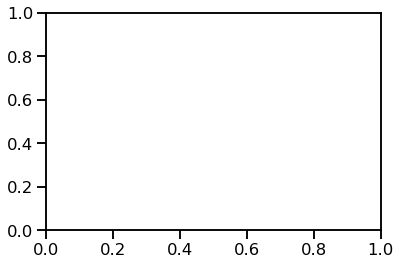

In [ ]:
loaded.plot('Ni')

## DAMASK simulations
Here, we use the above fits to the data from lammps MD simulation to find the elastic constansts for a selected set of Ni concentrations. Then these values are given to DAMASK simulations to obtain the macroscopic elasto-plastic response.    

In [ ]:
import os
cwd = os.getcwd()
print(cwd)
os.chdir(cwd)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-39150526ae69>", line 2, in <module>
    cwd = os.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/opt/conda/lib/python3.8/site-packages/IPytho

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-44-39150526ae69>", line 2, in <module>
    cwd = os.getcwd()
FileNotFoundError: [Errno 2] No such file or directory

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'FileNotFoundError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/in

In [44]:
concentrations=[0.2,0.6,1.0]

In [45]:
from damask import Geom
from damask import seeds
#import numpy as np
import subprocess,shlex
import os
import damask
from simulation_runner import simulation
simulation_folder =[]
job_file = []
grid = np.array([16,16,16])
size = np.array([1.0,1.0,1.0])
grains = 20
seeds = seeds.from_random(size,grains)
for i,c in enumerate(concentrations):
    os.chdir(cwd)
    simulation_folder.append('Ni-{}'.format(int(c*100)))
    os.system('mkdir {}'.format(simulation_folder[i]))
    os.system('cp Examples/material.yaml {}'.format(simulation_folder[i]))
    os.system('cp Examples/tensionX.load {}/tension_Ni{}.load'.format(simulation_folder[i],int(c*100)))
    path = cwd+'/'+simulation_folder[i];
    print(path)
    C11 = float(loaded.get_C11_poly('Ni')(c))
    C12 = float(loaded.get_C12_poly('Ni')(c))
    C44 = float(loaded.get_C44_poly('Ni')(c))
    print("moduli: {}, {}, {}".format(C11,C12,C44))
    print(simulation_folder[i])
    #os.chdir(simulation_folder[i])
    os.chdir(path)
#    os.system('rm *.hdf5')
    load = 'tension_Ni{}.load'.format(int(c*100))
    geom_name = 'test.geom'
    material_config = 'material.yaml'
    job_file.append('{}_{}.hdf5'.format(geom_name.split('.')[0],load.split('.')[0]))
    new_geom = Geom.from_Voronoi_tessellation(grid,size,seeds)
    new_geom.save_ASCII(geom_name)
    new_geom.save(geom_name.split('.')[0])
    C_matrix = [C11*1e9,C12*1e9,C44*1e9]
    elasticity={}
    elasticity.update({'type': 'hooke'})
    elastic_constants = {'C_11': C_matrix[0], 'C_12': C_matrix[1], 'C_44': C_matrix[2]}
    elasticity.update(elastic_constants)
    mat = damask.Config.load(material_config)
    mat['phase']['Aluminum']['elasticity'] = elasticity
    mat.save(material_config)
    simulation.run(simulation_folder[i],geom_name,load)
    print('simulation {} done'.format(str(i)))

ERROR! Session/line number was not unique in database. History logging moved to new session 44
/home/pyiron_user/pyiron/projects/pyiron_workflow_examples/LAMMPS-DAMASK-workflow/Ni-20


KeyError: 'compositions'

## post processing of DAMASK simulations
Here, the data from damask simulations are post-process to obtain the list of strain, stress, and Von-Mises stress.

In [ ]:
os.chdir(cwd)
import damask
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as PyPlot
import numpy as np
import h5py
#from Plot_stress_strain import plot
from damask_eval import eval_stress , eval_strain
%matplotlib inline
d = []
stresses = []
strains = []
#os.chdir(cwd)
for i,c in enumerate(concentrations):
    path = cwd+'/'+simulation_folder[i];
    os.chdir(path)
    #os.chdir(simulation_folder[i])
    d.append(damask.Result(job_file[i]))                  
    d[i].add_Cauchy()
    d[i].add_strain_tensor()
    d[i].add_Mises('sigma')
    d[i].add_Mises('epsilon_V^0.0(F)')
    d[i].add_calculation('avg_sigma',"np.average(#sigma_vM#)")
    d[i].add_calculation('avg_epsilon',"np.average(#epsilon_V^0.0(F)_vM#)")
    d[i].save_vtk(['sigma','epsilon_V^0.0(F)','sigma_vM','epsilon_V^0.0(F)_vM'])
    stresses.append(eval_stress(job_file[i]))
    strains.append(eval_strain(job_file[i]))

## Visualization
Here, you can find the stress-strain relation for different concentrations of Ni in a Cu-Ni alloy. The main difference lies in the elastic part. Therefore, the stain range is modified to visualize elastic deformation better.

Text(0.5, 1.0, 'Stress-Strain')

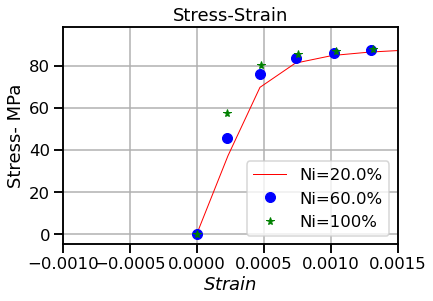

In [37]:
import matplotlib.pyplot as plt
i = 0;
#stresses[0]= eval_stress(job_file[0])
#stresses[1]= eval_stress(job_file[1])
#stresses[2]= eval_stress(job_file[2])
colors = ['r','g','b']
#for color, strain, stress, c in zip(colors, strains, stresses, concentrations):
plt.plot(strains[0], stresses[0], 'r', linewidth=1, label = 'Ni={}%'.format(0.2*100))
plt.plot(strains[1], stresses[1], 'b', linestyle="None",marker = 'o' ,markersize = 10,label = 'Ni={}%'.format(0.6*100))
plt.plot(strains[2], stresses[2], 'g', linestyle="None",marker = '*', markersize = 8 ,label = 'Ni={}%'.format(1*100))
plt.xlim(-0.001, 0.0015)
plt.grid(True)
plt.xlabel('$Strain$')
plt.ylabel('Stress- MPa')
plt.legend( loc='lower right')
plt.title("Stress-Strain")

## VTK Visualization

Import visualization modules

In [ ]:
import pyvista as pv
from itkwidgets import view

Visualizing initial geometry

In [ ]:
path = cwd+'/'+simulation_folder[i]
filepath = path + '/' + geom_name.split('.')[0] + '.vtr'
mesh = pv.read()
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()

Visualizing the stress strain distribution

In [ ]:
path = cwd+'/'+simulation_folder[i]
filepath = path + '/' + 'test_tension_Ni100_inc20.vtr'
mesh = pv.read()
pl = pv.PlotterITK()
pl.add_mesh(mesh)
pl.show()